## Testing Surrogated-Sources Approach

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow  as tf
from tensorflow.keras              import backend as K
from tensorflow.keras              import activations, initializers
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Layer, Dense, Activation, Dropout
from tensorflow.keras              import Input
from tensorflow.keras.regularizers import l2

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler

from scipy.integrate import solve_ivp

3.8.9 (default, Apr  3 2021, 01:51:00) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_10PSR_Clean_Lin/'
#OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_PSR_Clean_Test/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data_PSR_Clean_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NVarsRed           = 3

NPerRestTrain      = 2000
tStratch           = 1.
NtTrain            = NPerRestTrain*2
SOLVER             = 'BDF'

NNeurons           = [32,64,128,64,32]
Activations        = [activations.relu, activations.relu, activations.relu, activations.relu, activations.relu]
NEpoch             = 2500
NBatch             = 128
LearningRate       = 1.e-4
RegCoeff           = 1.e-4
OptimizerName      = tf.optimizers.Adam

In [3]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    
# NRests             = 10
# for iRest in range(NRests):

#     FileName     = OutputDir+'/pc_data_3/PC.csv.'+str(iRest+1) 
#     Data         = pd.read_csv(FileName, header=0)
#     tVec         = Data['t'].to_numpy()
#     yMat         = Data[Vars].to_numpy()
    
#     FileName     = OutputDir+'/pc_data_3/PCSource.csv.'+str(iRest+1) 
#     DataS        = pd.read_csv(FileName, header=0)
#     ySource      = DataS[SVars].to_numpy()
    
FileName     = OutputDir + '/orig_data/yCleaned.csv'
yMatOrig     = pd.read_csv(FileName, header=0)
VarNames     = list(yMatOrig.columns)
yMat         = yMatOrig.to_numpy()

FileName     = OutputDir + '/orig_data/RestVecTot.csv'
Data         = pd.read_csv(FileName, header=None)
RestVecTot   = np.log10(Data.to_numpy())
    
FileName     = OutputDir+'/orig_data/t.csv'
Data         = pd.read_csv(FileName, header=None)
tVec         = Data.to_numpy()[:,0]

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv'
Data         = pd.read_csv(FileName, header=0)
yMat_pca     = Data[Vars].to_numpy()

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv'
DataS        = pd.read_csv(FileName, header=0)
ySource_pca  = DataS[SVars].to_numpy()

In [4]:
# fig  = plt.figure(figsize=(16,12))
# plt.plot(tVec, yMat_pca[:,2], '-k',  linewidth=2)
# plt.xscale('log')

Text(0.5, 0, '$dPC_3/dt$')

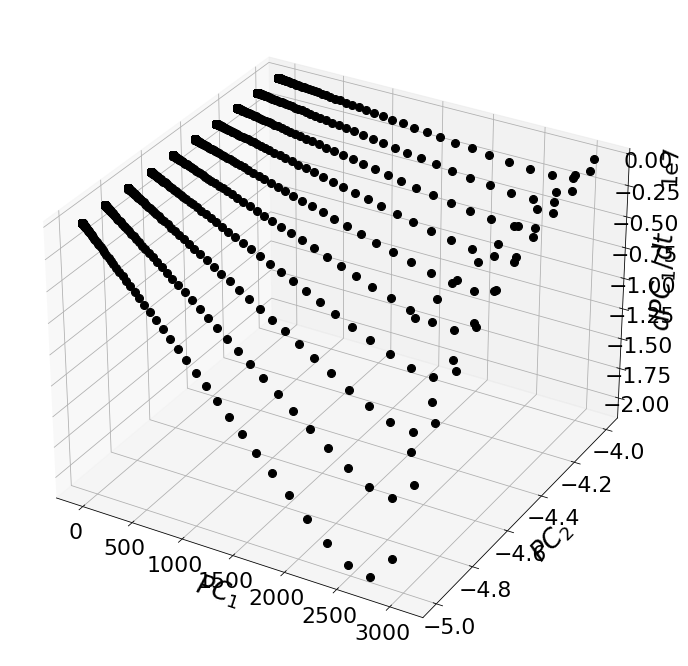

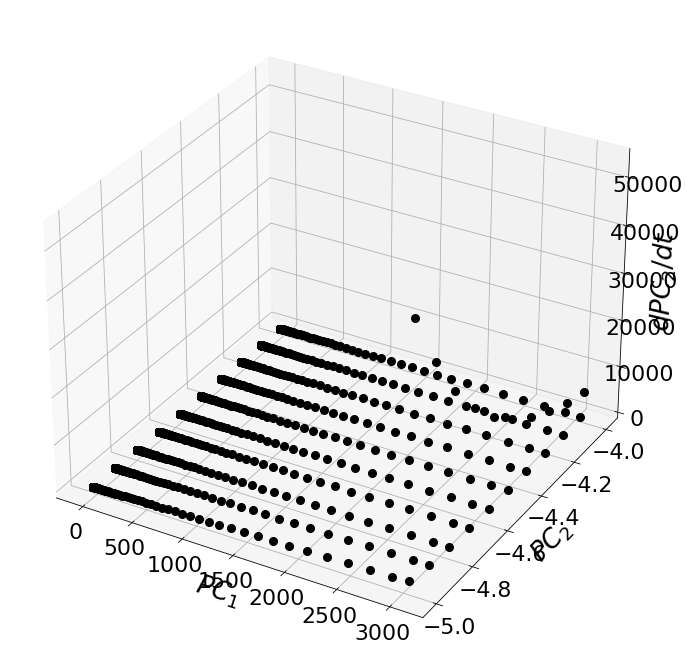

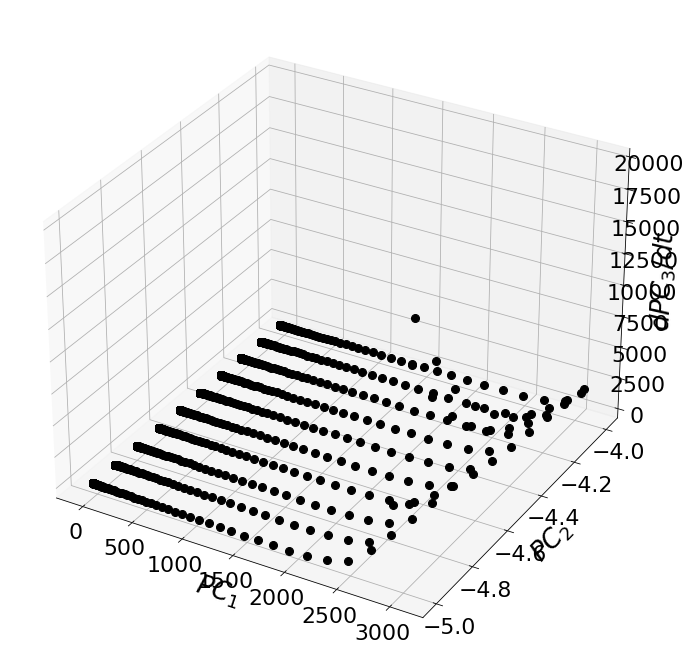

In [5]:
# Plotting Sources vs States

# fig  = plt.figure(figsize=(16,12))
# ax   = plt.axes(projection='3d')
# ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,0], 'ok',  linewidth=2)
# ax.set_xlabel(r'$PC_1$')
# ax.set_ylabel(r'$PC_2$')
# ax.set_zlabel(r'$dPC_1/dt$')

# fig  = plt.figure(figsize=(16,12))
# ax   = plt.axes(projection='3d')
# ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,1], 'ok',  linewidth=2)
# ax.set_xlabel(r'$PC_1$')
# ax.set_ylabel(r'$PC_2$')
# ax.set_zlabel(r'$dPC_2/dt$')

# fig  = plt.figure(figsize=(16,12))
# ax   = plt.axes(projection='3d')
# ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,2], 'ok',  linewidth=2)
# ax.set_xlabel(r'$PC_1$')
# ax.set_ylabel(r'$PC_2$')
# ax.set_zlabel(r'$dPC_3/dt$')




fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

In [6]:
### Normalizing Data

yMat_pca  = np.concatenate((yMat_pca, RestVecTot), axis=1)
xMax      = yMat_pca.max(0)
xMin      = yMat_pca.min(0)
xRange    = (xMax-xMin)
if (xRange[-1] == 0):
    xRange[-1] = 1.0
yMatt_pca = (yMat_pca-xMin)/xRange

yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
ySourcee_pca = (ySource_pca-yMin)/yRange

Nx = yMatt_pca.shape[1]
Nd = yMatt_pca.shape[0]
Ny = ySourcee_pca.shape[1]

Text(0.5, 0, '$dPC_3/dt$')

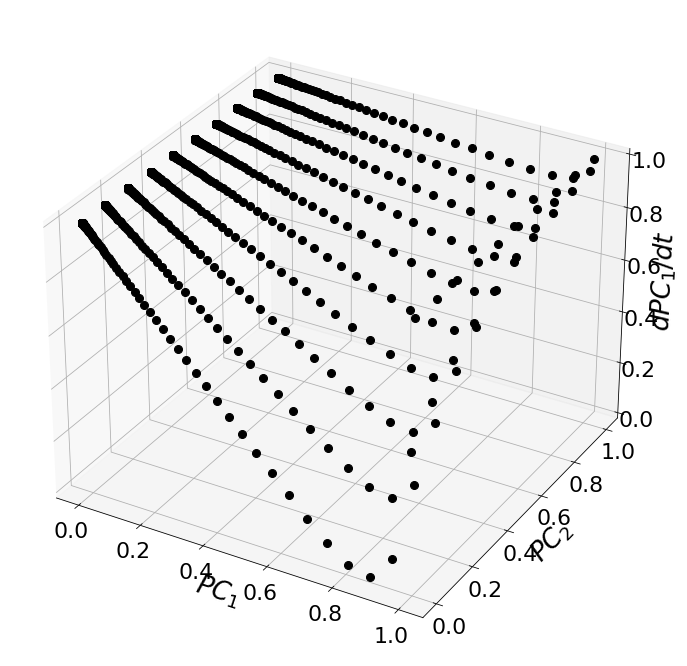

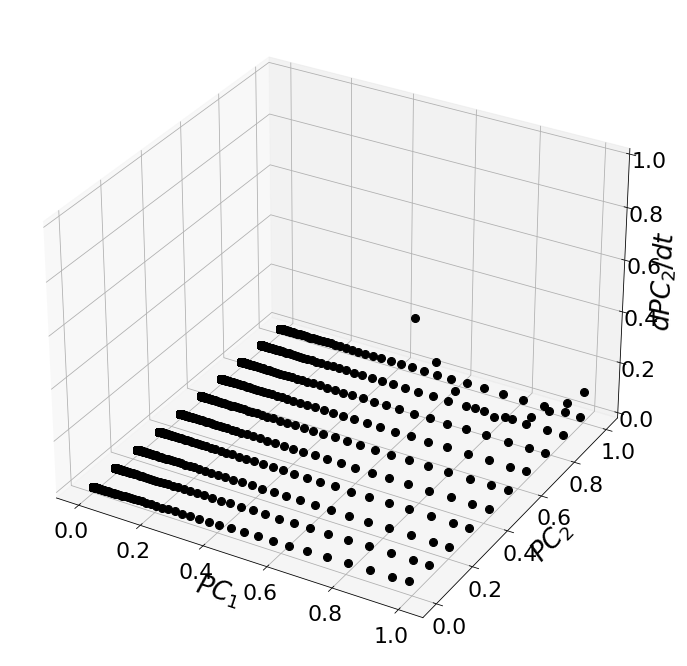

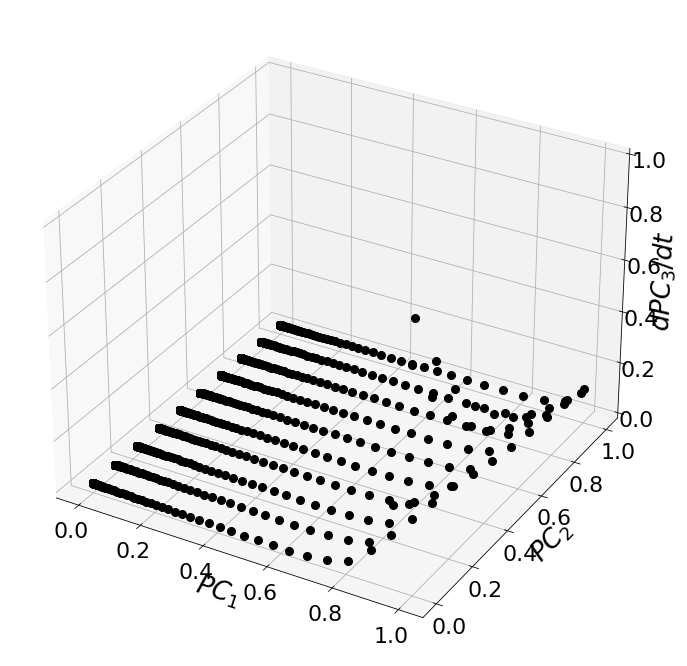

In [7]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

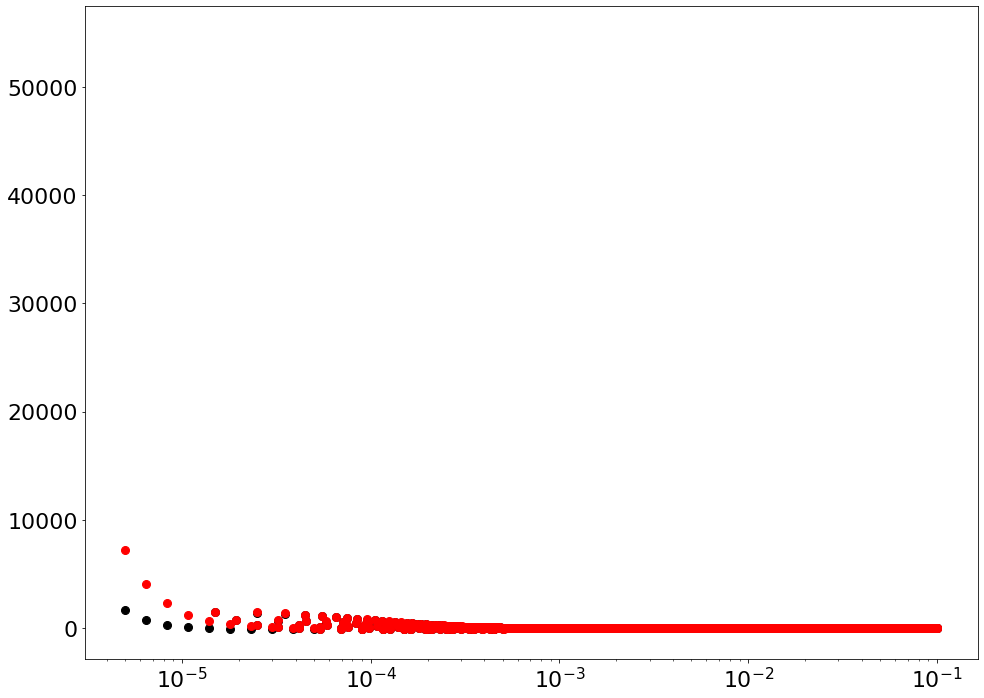

In [8]:
### Checking Data

from numpy import diff

iPC = 1

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[1:], dydt, 'ro')
plt.xscale('log')

In [9]:
### Splitting Data

XTrain, XTest, yTrain, yTest = train_test_split(yMatt_pca, ySourcee_pca, test_size=0.2, random_state=3)

In [10]:
### Creating Surrogate

NNModel = tf.keras.models.Sequential()

NNModel.add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
for iHL in range(1, len(NNeurons)):
    NNModel.add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
NNModel.add(Dense(Ny, activation='linear'))
NNModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 21,027
Trainable params: 21,027
Non-trainable params: 0
____________________________________________________

In [11]:
### Training Surrogate

Optimizer = OptimizerName(learning_rate=LearningRate)
NNModel.compile(optimizer=Optimizer, loss='mse')
Training  = NNModel.fit(XTrain, yTrain, batch_size=NBatch, epochs=NEpoch, validation_data=(XTest, yTest), verbose=1);

Epoch 1/2500
63/63 [==============================] - 1s 5ms/step - loss: 0.2831 - val_loss: 0.2149
Epoch 2/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.1468 - val_loss: 0.0828
Epoch 3/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0270
Epoch 4/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0244
Epoch 5/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 6/2500
63/63 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 7/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 8/2500
63/63 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0195
Epoch 9/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 10/2500
63/63 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0178

63/63 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 83/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 84/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 85/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 86/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 87/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 88/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 89/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 90/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 91/2500
63/63 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0034
Epoc

63/63 [==============================] - 0s 3ms/step - loss: 9.6606e-04 - val_loss: 0.0012
Epoch 163/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.5679e-04 - val_loss: 0.0012
Epoch 164/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.4858e-04 - val_loss: 0.0012
Epoch 165/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.4054e-04 - val_loss: 0.0012
Epoch 166/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.3314e-04 - val_loss: 0.0012
Epoch 167/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.2581e-04 - val_loss: 0.0012
Epoch 168/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.1873e-04 - val_loss: 0.0012
Epoch 169/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.1193e-04 - val_loss: 0.0012
Epoch 170/2500
63/63 [==============================] - 0s 3ms/step - loss: 9.0699e-04 - val_loss: 0.0012
Epoch 171/2500
63/63 [==============================] - 0s 3m

Epoch 239/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.9881e-04 - val_loss: 9.7200e-04
Epoch 240/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.9688e-04 - val_loss: 9.7076e-04
Epoch 241/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.9593e-04 - val_loss: 9.7027e-04
Epoch 242/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.9507e-04 - val_loss: 9.6894e-04
Epoch 243/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.9394e-04 - val_loss: 9.6721e-04
Epoch 244/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.9092e-04 - val_loss: 9.6547e-04
Epoch 245/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.8998e-04 - val_loss: 9.6406e-04
Epoch 246/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.8904e-04 - val_loss: 9.6318e-04
Epoch 247/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.8815e-04 - val_loss: 9.6155e-04
Epoch 248/

63/63 [==============================] - 0s 3ms/step - loss: 6.2171e-04 - val_loss: 9.0098e-04
Epoch 314/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.2202e-04 - val_loss: 9.0038e-04
Epoch 315/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.1998e-04 - val_loss: 8.9940e-04
Epoch 316/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.1970e-04 - val_loss: 8.9718e-04
Epoch 317/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.1835e-04 - val_loss: 9.0190e-04
Epoch 318/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.1819e-04 - val_loss: 8.9640e-04
Epoch 319/2500
63/63 [==============================] - 0s 6ms/step - loss: 6.1765e-04 - val_loss: 8.9701e-04
Epoch 320/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.1662e-04 - val_loss: 8.9822e-04
Epoch 321/2500
63/63 [==============================] - 0s 3ms/step - loss: 6.1572e-04 - val_loss: 8.9708e-04
Epoch 322/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 5.7733e-04 - val_loss: 8.6079e-04
Epoch 388/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7720e-04 - val_loss: 8.6025e-04
Epoch 389/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7756e-04 - val_loss: 8.5912e-04
Epoch 390/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7670e-04 - val_loss: 8.6147e-04
Epoch 391/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7667e-04 - val_loss: 8.5860e-04
Epoch 392/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7529e-04 - val_loss: 8.5786e-04
Epoch 393/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7475e-04 - val_loss: 8.5795e-04
Epoch 394/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7448e-04 - val_loss: 8.5818e-04
Epoch 395/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.7562e-04 - val_loss: 8.6129e-04
Epoch 396/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 5.5060e-04 - val_loss: 8.3715e-04
Epoch 462/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.5001e-04 - val_loss: 8.3584e-04
Epoch 463/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.5011e-04 - val_loss: 8.3595e-04
Epoch 464/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.5037e-04 - val_loss: 8.3896e-04
Epoch 465/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.4984e-04 - val_loss: 8.3473e-04
Epoch 466/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.4885e-04 - val_loss: 8.3427e-04
Epoch 467/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.4962e-04 - val_loss: 8.3675e-04
Epoch 468/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.4837e-04 - val_loss: 8.3406e-04
Epoch 469/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.4842e-04 - val_loss: 8.3608e-04
Epoch 470/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 5.3032e-04 - val_loss: 8.1969e-04
Epoch 536/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.3202e-04 - val_loss: 8.2202e-04
Epoch 537/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.3178e-04 - val_loss: 8.2205e-04
Epoch 538/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.3194e-04 - val_loss: 8.2141e-04
Epoch 539/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.3026e-04 - val_loss: 8.1766e-04
Epoch 540/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.2920e-04 - val_loss: 8.1858e-04
Epoch 541/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.3039e-04 - val_loss: 8.1726e-04
Epoch 542/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.2927e-04 - val_loss: 8.1832e-04
Epoch 543/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.2915e-04 - val_loss: 8.1909e-04
Epoch 544/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 5.1576e-04 - val_loss: 8.0603e-04
Epoch 610/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1618e-04 - val_loss: 8.0563e-04
Epoch 611/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1614e-04 - val_loss: 8.0587e-04
Epoch 612/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1539e-04 - val_loss: 8.0403e-04
Epoch 613/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1547e-04 - val_loss: 8.0429e-04
Epoch 614/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1615e-04 - val_loss: 8.0331e-04
Epoch 615/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1487e-04 - val_loss: 8.0618e-04
Epoch 616/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1510e-04 - val_loss: 8.0457e-04
Epoch 617/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.1552e-04 - val_loss: 8.0660e-04
Epoch 618/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 5.0516e-04 - val_loss: 7.9375e-04
Epoch 684/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0419e-04 - val_loss: 7.9363e-04
Epoch 685/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0400e-04 - val_loss: 7.9879e-04
Epoch 686/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0383e-04 - val_loss: 7.9575e-04
Epoch 687/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0368e-04 - val_loss: 7.9429e-04
Epoch 688/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0381e-04 - val_loss: 7.9907e-04
Epoch 689/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0344e-04 - val_loss: 7.9343e-04
Epoch 690/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0189e-04 - val_loss: 7.9374e-04
Epoch 691/2500
63/63 [==============================] - 0s 3ms/step - loss: 5.0239e-04 - val_loss: 7.9422e-04
Epoch 692/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 4.9290e-04 - val_loss: 7.8522e-04
Epoch 758/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9285e-04 - val_loss: 7.8405e-04
Epoch 759/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9338e-04 - val_loss: 7.8679e-04
Epoch 760/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9301e-04 - val_loss: 7.8373e-04
Epoch 761/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9266e-04 - val_loss: 7.8412e-04
Epoch 762/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9167e-04 - val_loss: 7.8335e-04
Epoch 763/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9198e-04 - val_loss: 7.8335e-04
Epoch 764/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9285e-04 - val_loss: 7.8338e-04
Epoch 765/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.9160e-04 - val_loss: 7.9024e-04
Epoch 766/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 4.8360e-04 - val_loss: 7.7629e-04
Epoch 832/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8377e-04 - val_loss: 7.7650e-04
Epoch 833/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8353e-04 - val_loss: 7.7763e-04
Epoch 834/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8334e-04 - val_loss: 7.7786e-04
Epoch 835/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8338e-04 - val_loss: 7.7721e-04
Epoch 836/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8319e-04 - val_loss: 7.7507e-04
Epoch 837/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8276e-04 - val_loss: 7.7735e-04
Epoch 838/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8351e-04 - val_loss: 7.7687e-04
Epoch 839/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.8200e-04 - val_loss: 7.7538e-04
Epoch 840/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 4.7595e-04 - val_loss: 7.7286e-04
Epoch 906/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7544e-04 - val_loss: 7.6867e-04
Epoch 907/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7540e-04 - val_loss: 7.6890e-04
Epoch 908/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7504e-04 - val_loss: 7.6899e-04
Epoch 909/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7437e-04 - val_loss: 7.7019e-04
Epoch 910/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7458e-04 - val_loss: 7.6858e-04
Epoch 911/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7454e-04 - val_loss: 7.6871e-04
Epoch 912/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7438e-04 - val_loss: 7.6767e-04
Epoch 913/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.7404e-04 - val_loss: 7.6787e-04
Epoch 914/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 4.6696e-04 - val_loss: 7.6334e-04
Epoch 980/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6779e-04 - val_loss: 7.5971e-04
Epoch 981/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6684e-04 - val_loss: 7.6164e-04
Epoch 982/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6778e-04 - val_loss: 7.6167e-04
Epoch 983/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6668e-04 - val_loss: 7.6175e-04
Epoch 984/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6684e-04 - val_loss: 7.6325e-04
Epoch 985/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6780e-04 - val_loss: 7.6418e-04
Epoch 986/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6652e-04 - val_loss: 7.6189e-04
Epoch 987/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6655e-04 - val_loss: 7.6200e-04
Epoch 988/2500
63/63 [===

63/63 [==============================] - 0s 3ms/step - loss: 4.6012e-04 - val_loss: 7.5429e-04
Epoch 1054/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6098e-04 - val_loss: 7.5510e-04
Epoch 1055/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6031e-04 - val_loss: 7.5374e-04
Epoch 1056/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6134e-04 - val_loss: 7.5901e-04
Epoch 1057/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6021e-04 - val_loss: 7.5504e-04
Epoch 1058/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.6105e-04 - val_loss: 7.5512e-04
Epoch 1059/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5966e-04 - val_loss: 7.5513e-04
Epoch 1060/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5943e-04 - val_loss: 7.5206e-04
Epoch 1061/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5940e-04 - val_loss: 7.5545e-04
Epoch 1062/2500
6

Epoch 1127/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5380e-04 - val_loss: 7.5207e-04
Epoch 1128/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5369e-04 - val_loss: 7.4984e-04
Epoch 1129/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5357e-04 - val_loss: 7.4877e-04
Epoch 1130/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5388e-04 - val_loss: 7.4929e-04
Epoch 1131/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5307e-04 - val_loss: 7.4865e-04
Epoch 1132/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5326e-04 - val_loss: 7.4888e-04
Epoch 1133/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5313e-04 - val_loss: 7.5067e-04
Epoch 1134/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5321e-04 - val_loss: 7.5018e-04
Epoch 1135/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.5357e-04 - val_loss: 7.4889e-04
E

Epoch 1201/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4809e-04 - val_loss: 7.4214e-04
Epoch 1202/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4737e-04 - val_loss: 7.4547e-04
Epoch 1203/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4774e-04 - val_loss: 7.4370e-04
Epoch 1204/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4711e-04 - val_loss: 7.4429e-04
Epoch 1205/2500
63/63 [==============================] - 0s 6ms/step - loss: 4.4694e-04 - val_loss: 7.4114e-04
Epoch 1206/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4723e-04 - val_loss: 7.4344e-04
Epoch 1207/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4707e-04 - val_loss: 7.4395e-04
Epoch 1208/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4732e-04 - val_loss: 7.4531e-04
Epoch 1209/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.4773e-04 - val_loss: 7.4578e-04
E

Epoch 1275/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4179e-04 - val_loss: 7.3944e-04
Epoch 1276/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4173e-04 - val_loss: 7.3696e-04
Epoch 1277/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4202e-04 - val_loss: 7.3906e-04
Epoch 1278/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4209e-04 - val_loss: 7.4379e-04
Epoch 1279/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4186e-04 - val_loss: 7.3907e-04
Epoch 1280/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4153e-04 - val_loss: 7.3768e-04
Epoch 1281/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4185e-04 - val_loss: 7.3577e-04
Epoch 1282/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4186e-04 - val_loss: 7.4072e-04
Epoch 1283/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.4184e-04 - val_loss: 7.4151e-04
E

Epoch 1349/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3714e-04 - val_loss: 7.3243e-04
Epoch 1350/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3694e-04 - val_loss: 7.3527e-04
Epoch 1351/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3724e-04 - val_loss: 7.3477e-04
Epoch 1352/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3692e-04 - val_loss: 7.3480e-04
Epoch 1353/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3674e-04 - val_loss: 7.3454e-04
Epoch 1354/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3622e-04 - val_loss: 7.3234e-04
Epoch 1355/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3646e-04 - val_loss: 7.3532e-04
Epoch 1356/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3647e-04 - val_loss: 7.3295e-04
Epoch 1357/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3602e-04 - val_loss: 7.3460e-04
E

Epoch 1423/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3292e-04 - val_loss: 7.3166e-04
Epoch 1424/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3218e-04 - val_loss: 7.3161e-04
Epoch 1425/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3230e-04 - val_loss: 7.3374e-04
Epoch 1426/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3209e-04 - val_loss: 7.3115e-04
Epoch 1427/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3200e-04 - val_loss: 7.3152e-04
Epoch 1428/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3178e-04 - val_loss: 7.3200e-04
Epoch 1429/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3154e-04 - val_loss: 7.2760e-04
Epoch 1430/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3220e-04 - val_loss: 7.3325e-04
Epoch 1431/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.3189e-04 - val_loss: 7.2913e-04
E

Epoch 1497/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2772e-04 - val_loss: 7.2653e-04
Epoch 1498/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2726e-04 - val_loss: 7.2344e-04
Epoch 1499/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2746e-04 - val_loss: 7.2435e-04
Epoch 1500/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2723e-04 - val_loss: 7.2836e-04
Epoch 1501/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2727e-04 - val_loss: 7.2539e-04
Epoch 1502/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2747e-04 - val_loss: 7.2658e-04
Epoch 1503/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2728e-04 - val_loss: 7.2692e-04
Epoch 1504/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2803e-04 - val_loss: 7.2761e-04
Epoch 1505/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2708e-04 - val_loss: 7.2657e-04
E

Epoch 1571/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2269e-04 - val_loss: 7.2042e-04
Epoch 1572/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2387e-04 - val_loss: 7.2372e-04
Epoch 1573/2500
63/63 [==============================] - 0s 2ms/step - loss: 4.2322e-04 - val_loss: 7.2158e-04
Epoch 1574/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2331e-04 - val_loss: 7.2209e-04
Epoch 1575/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2279e-04 - val_loss: 7.2166e-04
Epoch 1576/2500
63/63 [==============================] - 0s 2ms/step - loss: 4.2261e-04 - val_loss: 7.2271e-04
Epoch 1577/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2261e-04 - val_loss: 7.2164e-04
Epoch 1578/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2266e-04 - val_loss: 7.2254e-04
Epoch 1579/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.2242e-04 - val_loss: 7.2156e-04
E

Epoch 1645/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1980e-04 - val_loss: 7.2114e-04
Epoch 1646/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1920e-04 - val_loss: 7.1902e-04
Epoch 1647/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1824e-04 - val_loss: 7.1796e-04
Epoch 1648/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1891e-04 - val_loss: 7.1965e-04
Epoch 1649/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1858e-04 - val_loss: 7.1701e-04
Epoch 1650/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1896e-04 - val_loss: 7.1845e-04
Epoch 1651/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1900e-04 - val_loss: 7.1738e-04
Epoch 1652/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1799e-04 - val_loss: 7.1780e-04
Epoch 1653/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1885e-04 - val_loss: 7.1951e-04
E

Epoch 1719/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1603e-04 - val_loss: 7.1822e-04
Epoch 1720/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1470e-04 - val_loss: 7.1573e-04
Epoch 1721/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1479e-04 - val_loss: 7.1517e-04
Epoch 1722/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1525e-04 - val_loss: 7.1398e-04
Epoch 1723/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1468e-04 - val_loss: 7.1439e-04
Epoch 1724/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1487e-04 - val_loss: 7.1450e-04
Epoch 1725/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1510e-04 - val_loss: 7.1407e-04
Epoch 1726/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1511e-04 - val_loss: 7.1526e-04
Epoch 1727/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1474e-04 - val_loss: 7.1698e-04
E

Epoch 1793/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1401e-04 - val_loss: 7.1041e-04
Epoch 1794/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1104e-04 - val_loss: 7.1219e-04
Epoch 1795/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1113e-04 - val_loss: 7.1330e-04
Epoch 1796/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1347e-04 - val_loss: 7.1041e-04
Epoch 1797/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1359e-04 - val_loss: 7.1310e-04
Epoch 1798/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1220e-04 - val_loss: 7.1308e-04
Epoch 1799/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1228e-04 - val_loss: 7.1644e-04
Epoch 1800/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1218e-04 - val_loss: 7.1521e-04
Epoch 1801/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.1304e-04 - val_loss: 7.1597e-04
E

Epoch 1867/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0841e-04 - val_loss: 7.0898e-04
Epoch 1868/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0859e-04 - val_loss: 7.0872e-04
Epoch 1869/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0773e-04 - val_loss: 7.1061e-04
Epoch 1870/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0873e-04 - val_loss: 7.1096e-04
Epoch 1871/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0891e-04 - val_loss: 7.0867e-04
Epoch 1872/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0806e-04 - val_loss: 7.0610e-04
Epoch 1873/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0855e-04 - val_loss: 7.1041e-04
Epoch 1874/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0973e-04 - val_loss: 7.0729e-04
Epoch 1875/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0771e-04 - val_loss: 7.0884e-04
E

Epoch 1941/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0456e-04 - val_loss: 7.0330e-04
Epoch 1942/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0444e-04 - val_loss: 7.0633e-04
Epoch 1943/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0486e-04 - val_loss: 7.0530e-04
Epoch 1944/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0434e-04 - val_loss: 7.0549e-04
Epoch 1945/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0434e-04 - val_loss: 7.0525e-04
Epoch 1946/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0470e-04 - val_loss: 7.0672e-04
Epoch 1947/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0534e-04 - val_loss: 7.0643e-04
Epoch 1948/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0636e-04 - val_loss: 7.0896e-04
Epoch 1949/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0490e-04 - val_loss: 7.0744e-04
E

Epoch 2015/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0263e-04 - val_loss: 7.0603e-04
Epoch 2016/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0192e-04 - val_loss: 7.0325e-04
Epoch 2017/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0236e-04 - val_loss: 7.0868e-04
Epoch 2018/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0194e-04 - val_loss: 7.0326e-04
Epoch 2019/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0184e-04 - val_loss: 7.0190e-04
Epoch 2020/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0138e-04 - val_loss: 7.0249e-04
Epoch 2021/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0224e-04 - val_loss: 7.0341e-04
Epoch 2022/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0103e-04 - val_loss: 7.0179e-04
Epoch 2023/2500
63/63 [==============================] - 0s 3ms/step - loss: 4.0153e-04 - val_loss: 7.0222e-04
E

Epoch 2089/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9990e-04 - val_loss: 7.0157e-04
Epoch 2090/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9999e-04 - val_loss: 6.9993e-04
Epoch 2091/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9870e-04 - val_loss: 7.0058e-04
Epoch 2092/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9913e-04 - val_loss: 7.0127e-04
Epoch 2093/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9890e-04 - val_loss: 7.0130e-04
Epoch 2094/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9940e-04 - val_loss: 7.0250e-04
Epoch 2095/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9888e-04 - val_loss: 6.9958e-04
Epoch 2096/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9899e-04 - val_loss: 7.0084e-04
Epoch 2097/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9903e-04 - val_loss: 7.0077e-04
E

Epoch 2163/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9639e-04 - val_loss: 6.9926e-04
Epoch 2164/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9618e-04 - val_loss: 6.9845e-04
Epoch 2165/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9562e-04 - val_loss: 6.9634e-04
Epoch 2166/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9651e-04 - val_loss: 6.9529e-04
Epoch 2167/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9613e-04 - val_loss: 6.9792e-04
Epoch 2168/2500
63/63 [==============================] - 0s 2ms/step - loss: 3.9650e-04 - val_loss: 6.9713e-04
Epoch 2169/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9629e-04 - val_loss: 6.9545e-04
Epoch 2170/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9604e-04 - val_loss: 6.9818e-04
Epoch 2171/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9559e-04 - val_loss: 6.9677e-04
E

Epoch 2237/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9291e-04 - val_loss: 6.9244e-04
Epoch 2238/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9473e-04 - val_loss: 6.9704e-04
Epoch 2239/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9354e-04 - val_loss: 6.9702e-04
Epoch 2240/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9359e-04 - val_loss: 6.9574e-04
Epoch 2241/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9352e-04 - val_loss: 6.9610e-04
Epoch 2242/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9313e-04 - val_loss: 6.9454e-04
Epoch 2243/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9330e-04 - val_loss: 7.0019e-04
Epoch 2244/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9376e-04 - val_loss: 6.9475e-04
Epoch 2245/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9340e-04 - val_loss: 6.9627e-04
E

Epoch 2311/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9088e-04 - val_loss: 6.9483e-04
Epoch 2312/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9213e-04 - val_loss: 6.9186e-04
Epoch 2313/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9059e-04 - val_loss: 6.9543e-04
Epoch 2314/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9053e-04 - val_loss: 6.9273e-04
Epoch 2315/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9099e-04 - val_loss: 6.9224e-04
Epoch 2316/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9023e-04 - val_loss: 6.9155e-04
Epoch 2317/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9076e-04 - val_loss: 6.9289e-04
Epoch 2318/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8982e-04 - val_loss: 6.9156e-04
Epoch 2319/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.9162e-04 - val_loss: 6.9436e-04
E

Epoch 2385/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8809e-04 - val_loss: 6.9006e-04
Epoch 2386/2500
63/63 [==============================] - 0s 4ms/step - loss: 3.8825e-04 - val_loss: 6.8991e-04
Epoch 2387/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8820e-04 - val_loss: 6.8888e-04
Epoch 2388/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8859e-04 - val_loss: 6.9011e-04
Epoch 2389/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8896e-04 - val_loss: 6.9029e-04
Epoch 2390/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8874e-04 - val_loss: 6.9173e-04
Epoch 2391/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8937e-04 - val_loss: 6.9297e-04
Epoch 2392/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8853e-04 - val_loss: 6.9128e-04
Epoch 2393/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8825e-04 - val_loss: 6.9314e-04
E

Epoch 2459/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8720e-04 - val_loss: 6.8764e-04
Epoch 2460/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8628e-04 - val_loss: 6.8981e-04
Epoch 2461/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8640e-04 - val_loss: 6.8610e-04
Epoch 2462/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8705e-04 - val_loss: 6.8877e-04
Epoch 2463/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8704e-04 - val_loss: 6.8771e-04
Epoch 2464/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8632e-04 - val_loss: 6.8898e-04
Epoch 2465/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8541e-04 - val_loss: 6.9114e-04
Epoch 2466/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8669e-04 - val_loss: 6.9218e-04
Epoch 2467/2500
63/63 [==============================] - 0s 3ms/step - loss: 3.8562e-04 - val_loss: 6.8773e-04
E

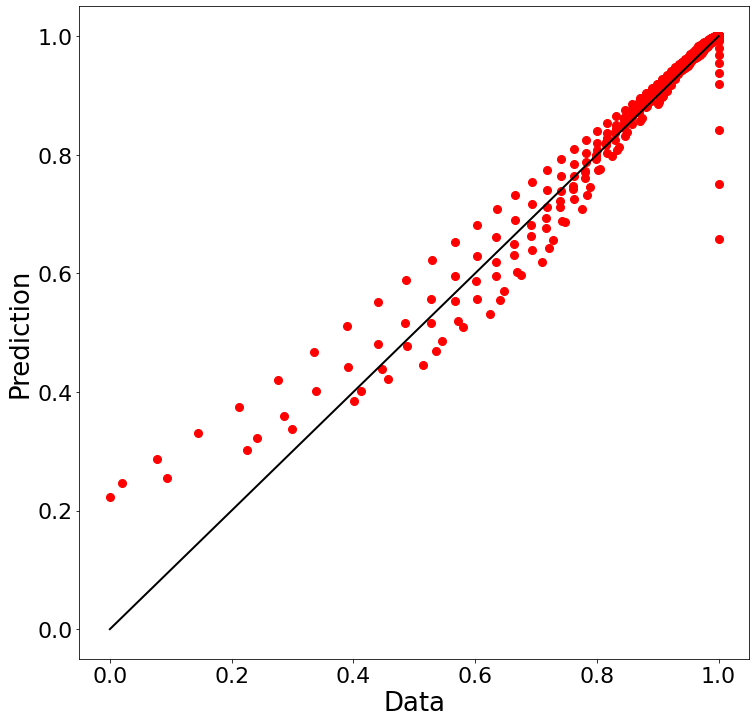

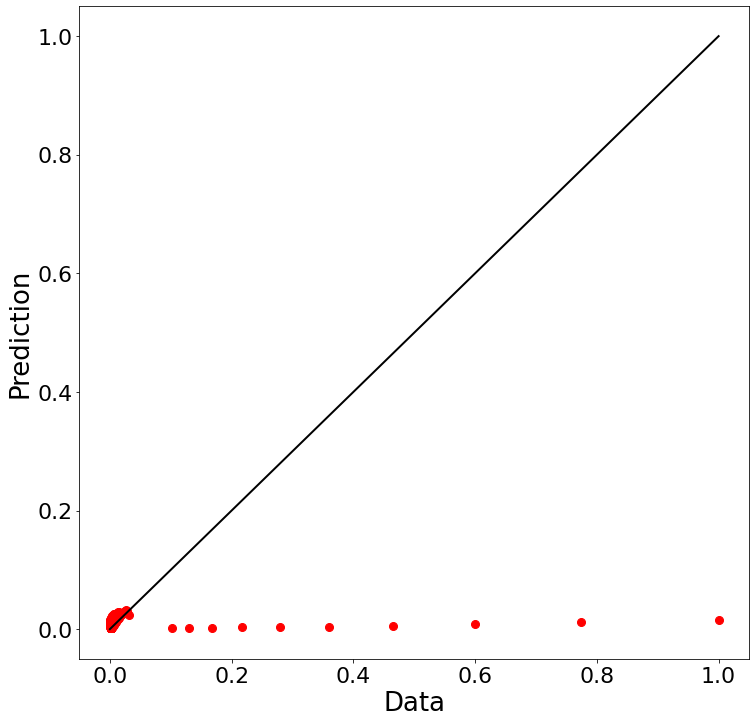

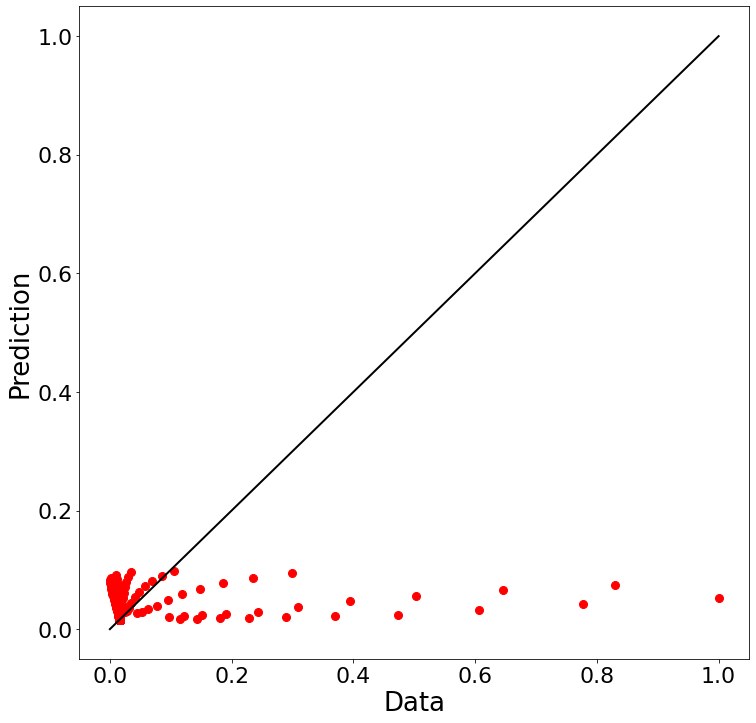

In [12]:
### Checking Predictive Accuracy

ySource_pca_ = NNModel.predict(yMatt_pca)

for iy in range(Ny):
    fig  = plt.figure(figsize=(12,12))
    xMin_ = np.amin(ySourcee_pca[:,iy])
    xMax_ = np.amax(ySourcee_pca[:,iy])
    plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
    plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    plt.xlabel('Data')
    plt.ylabel('Prediction')

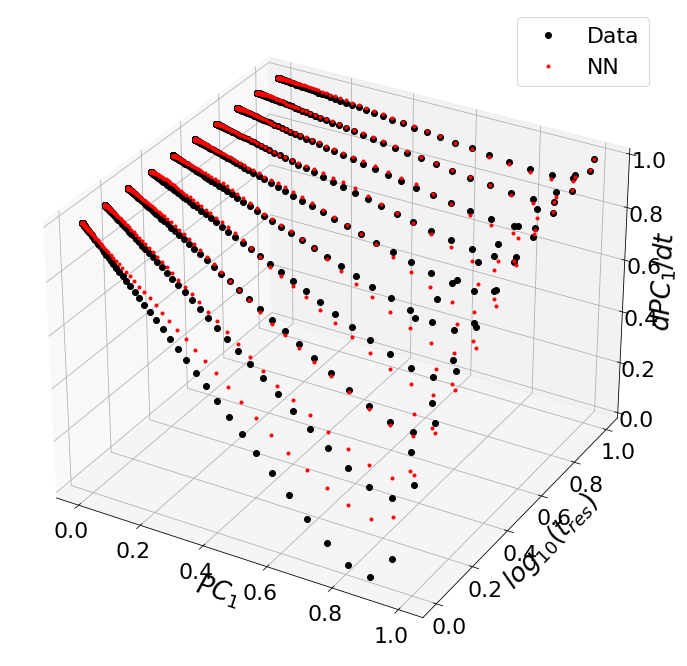

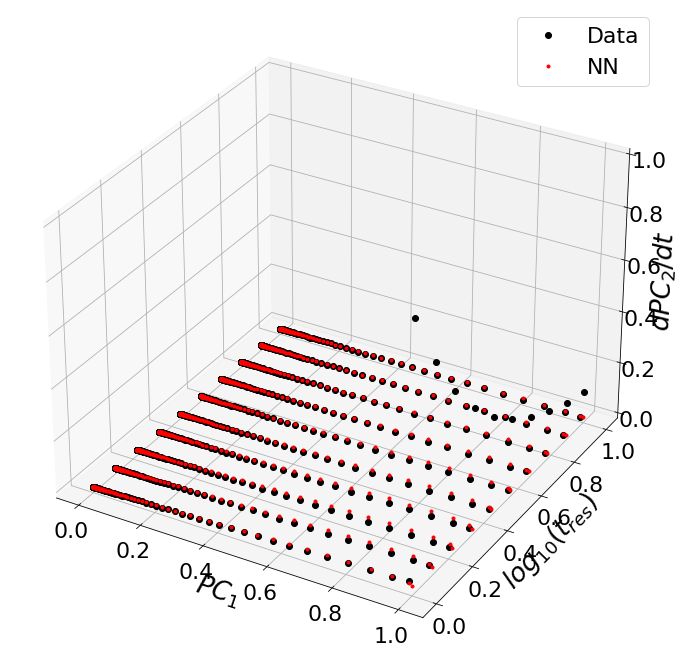

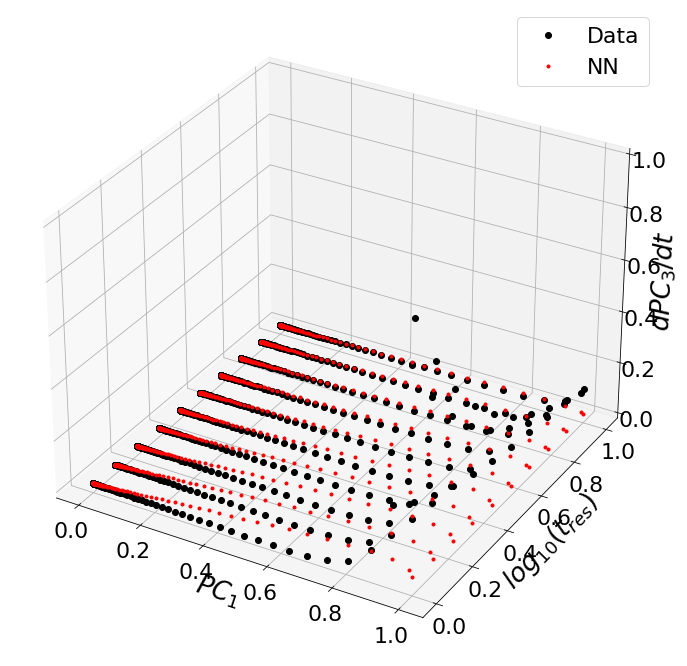

In [13]:
ySourcee_pca_ = NNModel.predict(yMatt_pca)


fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,0],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,0], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_1/dt$')
ax.legend()

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,1],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,1], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_2/dt$')
ax.legend()

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,2],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,2], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_3/dt$')
ax.legend()


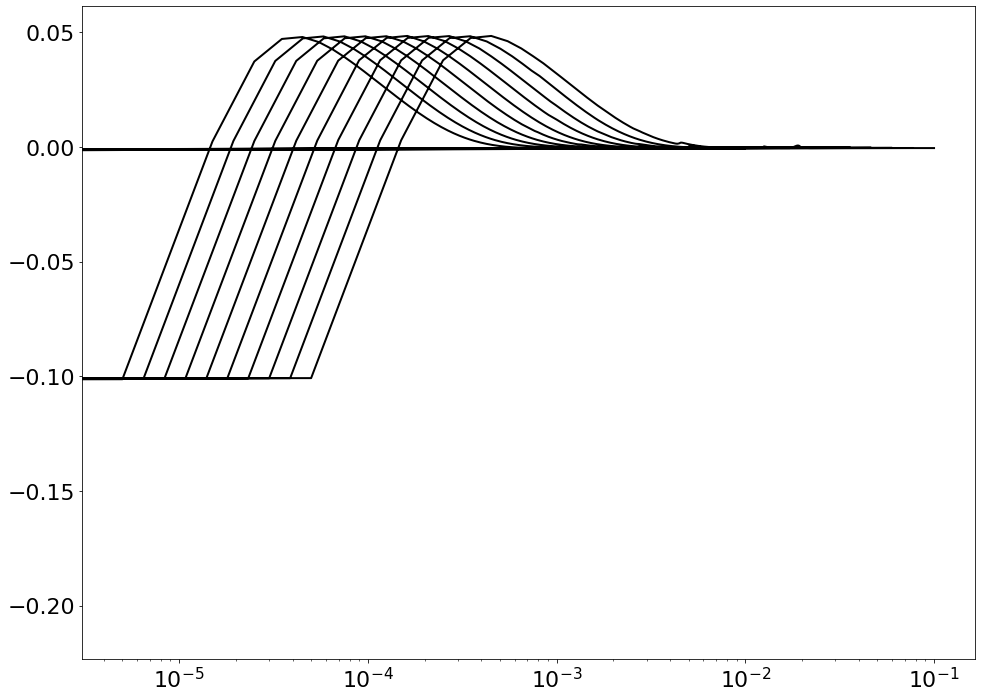

In [14]:
fig  = plt.figure(figsize=(16,12))
plt.plot( tVec, yMat_pca[:,2], '-k',  linewidth=2)
plt.xscale('log')

In [15]:
# NNModel = []

# for iy in range(1,2):


#     ### Creating Surrogate

#     LengthScale               = 5.e-2
#     Tau                       = 1.
#     RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

#     NNModel.append(tf.keras.models.Sequential())

#     NNModel[-1].add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     for iHL in range(1, len(NNeurons)):
#         NNModel[-1].add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     NNModel[-1].add(Dense(Ny, activation='linear'))
#     NNModel[-1].summary()



#     ### Training Surrogate

#     Optimizer = OptimizerName(learning_rate=LearningRate)
#     NNModel[-1].compile(optimizer=Optimizer, loss='mse')
#     Training  = NNModel[-1].fit(XTrain, yTrain[:,iy], batch_size=NBatch, epochs=1000, validation_data=(XTest, yTest[:,iy]), verbose=1);

#     LossTrainHystory = Training.history['loss']
#     LossValidHystory = Training.history['val_loss']



#     # Plotting Training and Validation Loss

#     fig = plt.figure(figsize=(12, 8))
#     plt.plot(LossTrainHystory, 'r', label='Training')
#     plt.plot(LossValidHystory, 'g', label='Validation')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.yscale('log')
#     plt.legend()
# #     FigPath = FigDir+'/TrainingNN_'+str(NEpoch)+'Epoches_PCSources.png'
# #     fig.savefig(FigPath, dpi=900)
    
    
    
#     ### Checking Predictive Accuracy

#     ySource_pca_ = NNModel[-1].predict(yMatt_pca)

#     fig  = plt.figure(figsize=(12,12))
#     xMin_ = np.amin(ySourcee_pca[:,iy])
#     xMax_ = np.amax(ySourcee_pca[:,iy])
#     plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
#     plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
#     plt.xlabel('Data')
#     plt.ylabel('Prediction')

In [16]:
# ySource_pca_ = NNModel[-1].predict(yMatt_pca)

# fig  = plt.figure(figsize=(12,12))
# xMin_ = np.amin(ySourcee_pca[:,iy])
# xMax_ = np.amax(ySourcee_pca[:,iy])
# plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
# plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
# plt.xlabel('Data')
# plt.ylabel('Prediction')

In [17]:
### Defining Surrogate ODE

def fOrig_NN(t, y):
    print(t)
    #yy   = (y - xMin)/xRange
    yy   = (np.append(y, RestVal) - xMin)/xRange
    dydt = NNModel.predict(yy[np.newaxis,...])
    dydt = dydt*yRange + yMin
    return dydt[0,:]

y0_pca =  [ 3.08075035e+03 -1.05154087e-02 -2.10205172e-01]
RestVal =  [-4.15490196]


<Figure size 1152x864 with 0 Axes>

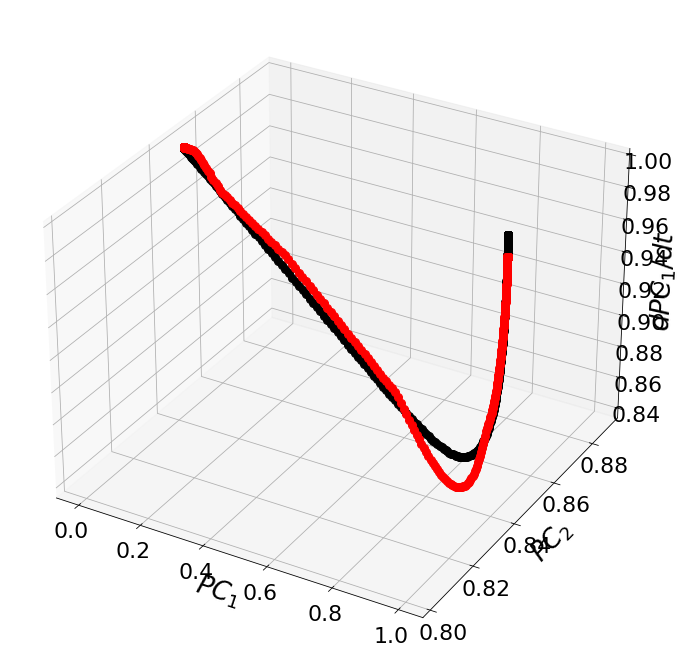

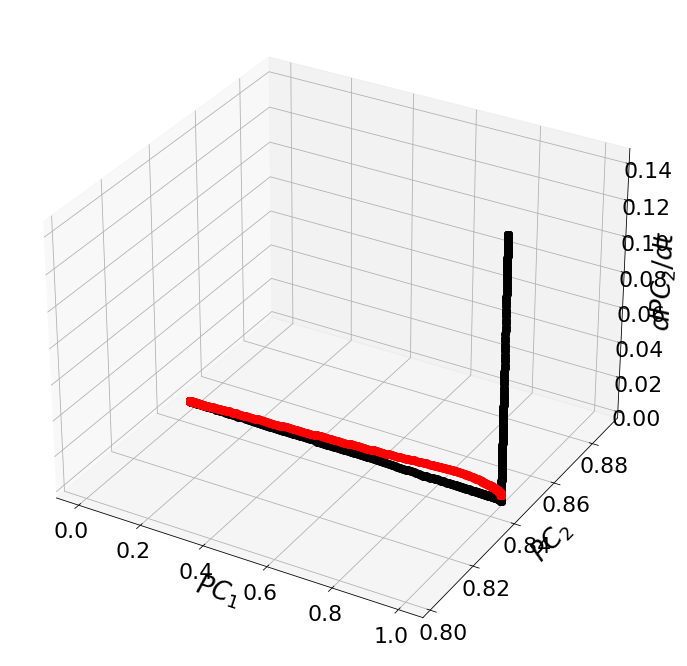

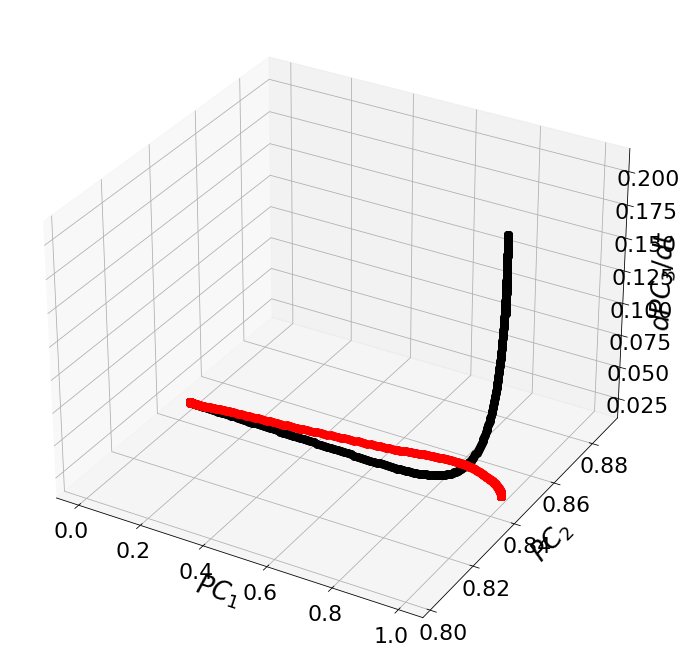

In [18]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    #tVec         = Data.to_numpy()[:,0]
    ySource_pca  = Data[SVars].to_numpy()
    ySourcee_pca = (ySource_pca-yMin)/yRange

    
    RestVal      = RestValVecTest[iTest]
    print('RestVal = ', RestVal)
    
    yMatt_pca     = (np.concatenate( (yMat_pca, RestVal*np.ones((yMat_pca.shape[0],1))), axis=1) - xMin)/xRange
    ySourcee_pca_ = NNModel.predict(yMatt_pca)
    ySource_pca_  = yRange*ySourcee_pca_ + yMin
     

        
    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,0],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,0], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_1/dt$')

    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,1],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,1], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_2/dt$')

    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,2],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,2], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_3/dt$')

y0_pca =  [ 3.08075035e+03 -1.05154087e-02 -2.10205172e-01]
0.0
5.387397709394825e-06
0.0001077479541878965
0.00016162193128184475
0.000430991816751586
0.0004788797963906511
0.0005387397709394825
0.0005387397709394825
0.0009303372841798876
0.00112613604080009
0.0021051298239011026
0.00227917316311906
0.0024967273371415072
0.0024967273371415072
0.004200790888090886
0.005052822663565575
0.00931298154093902
0.010070343119138745
0.0110170450918884
0.0110170450918884
0.012592864187242118
0.013380773734918977
0.017320321473303275
0.018020685515682703
0.018896140568656992
0.018896140568656992
0.025251029752325932
0.028428474344160397
0.04431569730333275
0.047140092496074495
0.05067058648700168
0.05067058648700168
0.05453646918960134
0.05646941054090117
0.06613411729740032
0.06785228738744462
0.06999999999999998
0.06999999999999998


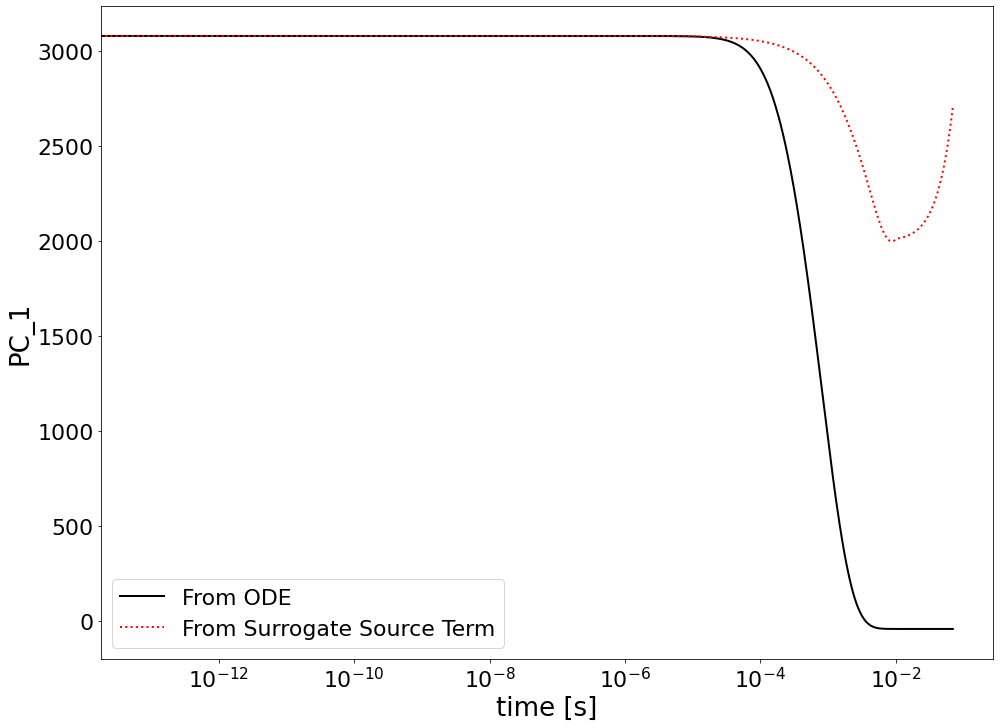

In [19]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/RestVecTot.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    RestVal      = RestValVecTest[iTest]
    
    plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE', lw=2)
    
    output       = solve_ivp( fOrig_NN, tVec[[0,-1]], y0_pca, method='RK45', t_eval=tVec, atol=1.e-8 )
    tNN          = output.t
    yMat_pca_    = output.y.T
    
    plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('PC_'+str(iPC+1))
plt.legend()

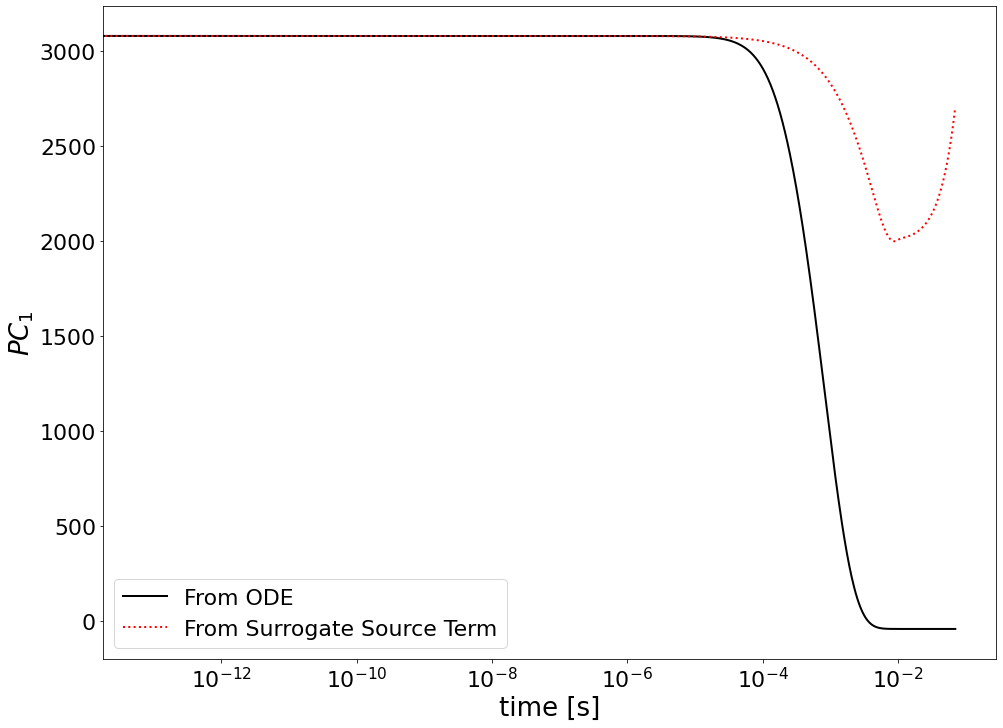

In [20]:
iPC = 0

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE',                   lw=2)
plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)
plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('$PC_'+str(iPC+1)+'$')
plt.legend()
#plt.ylim([-2000.0, 2500.])

In [21]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [22]:
yMat_    = (yMat_pca_.dot(A))*D[:,0] + C[:,0]

iVar =  16


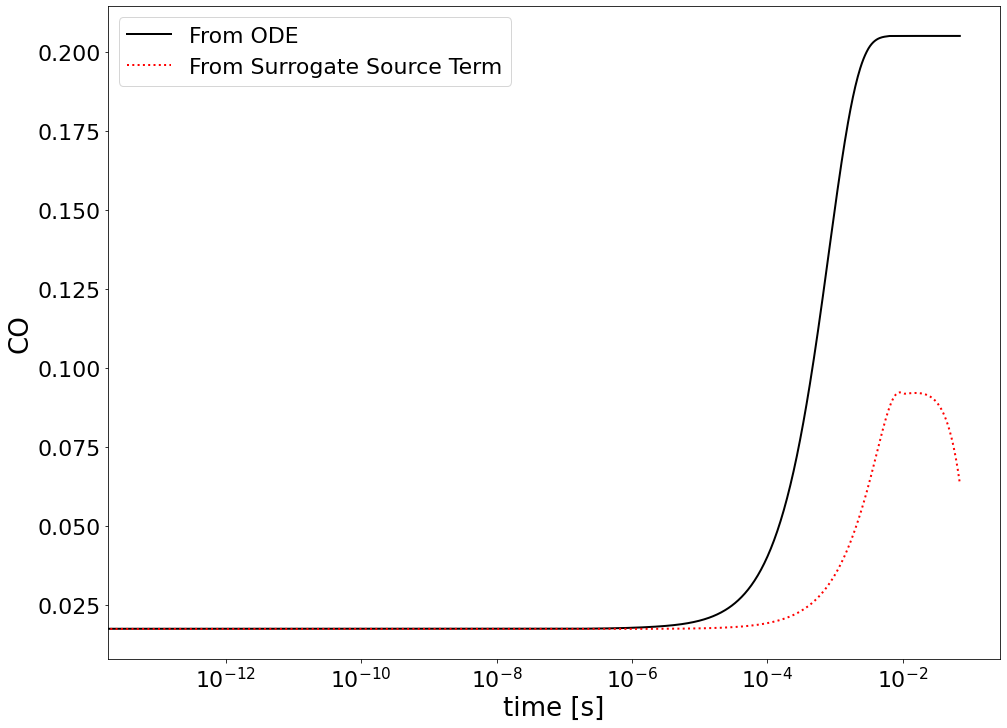

In [23]:
VarOI = 'CO'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat         = Data.to_numpy()[:,1:]
        
    plt.plot(tVec, yMat[:,iVar-1], '-k', label='From ODE',                   lw=2)
    plt.plot(tNN, yMat_[:,iVar-1], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel(VarOI)
plt.legend()

In [24]:
ModelFile = OutputDir + '/NN_Sources/'

NNModel.save(ModelFile)

INFO:tensorflow:Assets written to: /Users/sventuri/WORKSPACE//ROMNet/Data_10PSR_Clean_Lin//NN_Sources/assets


In [25]:
### Write Data

FileName       = OutputDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVec     = np.log10(Data.to_numpy())

for iTrain in range(10):

    FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTrain+1)
    Data         = pd.read_csv(FileName, header=0)
    yMat_pca     = Data[Vars].to_numpy()
    
    RestVal      = RestValVec[iTrain]
    RestVec      = np.ones((yMat_pca.shape[0],1)) * RestVal
    yMat_pca     = np.concatenate( (yMat_pca, RestVec), axis=1 )
    
    FileName     = '/Users/sventuri/Desktop/Data/PC_Augmented.csv.'+str(iTrain+1)
    Header       = 'PC1,PC2,PC3,log10(ResTime)'
    np.savetxt(FileName, yMat_pca, delimiter=',', header=Header, comments='')
    
    
    
    
    FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv.'+str(iTrain+1)
    Data         = pd.read_csv(FileName, header=0)
    ySources_pca = Data[SVars].to_numpy()
    
    FileName     = '/Users/sventuri/Desktop/Data/PCSource.csv.'+str(iTrain+1)
    Header       = 'SPC1,SPC2,SPC3'
    np.savetxt(FileName, ySources_pca, delimiter=',', header=Header, comments='')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sventuri/Desktop/Data/PC_Augmented.csv.1'